In [ ]:
!pip install dmba

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 77.8 MB/s eta 0:00:00


In [ ]:
from pathlib import Path

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso, Ridge, LassoCV, BayesianRidge
import statsmodels.formula.api as sm
import matplotlib.pylab as plt
import numpy as np
import seaborn as sb

import dmba
from dmba import regressionSummary, exhaustive_search
from dmba import backward_elimination, forward_selection, stepwise_selection
from dmba import adjusted_r2_score, AIC_score, BIC_score
from sklearn.linear_model import LogisticRegression
from itertools import combinations
from sklearn.base import clone
from sklearn.metrics import accuracy_score
from dmba import classificationSummary, gainsChart, liftChart
%matplotlib inline

Colab environment detected.


In [ ]:
path = '/content/drive/MyDrive/datasets/epl2020.exc.xlsx'

In [ ]:
epl = pd.read_excel(path)

In [ ]:
clean= epl.drop(['deep', 'deep_allowed', 'scored', 'missed', 'pts', 'matchtime', 'ppda_cal', 'allowed_ppda', 'round', 'HS.x', 'HST.x', 'HF.x', 'HC.x', 'HY.x', 'HR.x', 'AS.x', 'AST.x', 'AF.x', 'AC.x', 'AY.x', 'AR.x', 'draws', 'wins','result','date','B365H.x','B365D.x','B365A.x','Referee.x', 'matchDay', 'teamId'], axis=1)

In [ ]:
sliced= (clean[50:])

In [ ]:
X = sliced.drop(columns=['loses'])
Y = sliced['loses']

In [ ]:
print(X)

     Unnamed: 0        xG       xGA      npxG     npxGA    xpts     npxGD  \
50           51  2.293480  3.457680  2.293480  2.696510  0.6389 -0.403030   
51           52  3.457680  2.293480  2.696510  2.293480  2.1833  0.403030   
52           53  0.985542  2.788210  0.985542  2.027040  0.3434 -1.041498   
53           54  2.788210  0.985542  2.027040  0.985542  2.5205  1.041498   
54           55  1.893450  3.128560  1.893450  3.128560  0.6611 -1.235110   
..          ...       ...       ...       ...       ...     ...       ...   
571         572  0.445922  2.028830  0.445922  2.028830  0.2901 -1.582908   
572         573  0.585469  1.738900  0.585469  1.738900  0.3539 -1.153431   
573         574  1.738900  0.585469  1.738900  0.585469  2.4269  1.153431   
574         575  0.672448  2.412390  0.672448  1.651220  0.2673 -0.978772   
575         576  2.412390  0.672448  1.651220  0.672448  2.5950  0.978772   

     tot_points  tot_goal  tot_con  HtrgPerc  AtrgPerc  h_a_h_a_a  
50     

In [ ]:
print(Y)

50     1
51     0
52     1
53     0
54     1
      ..
571    1
572    1
573    0
574    1
575    0
Name: loses, Length: 526, dtype: int64


In [ ]:
#sliced['h_a_h_a'] = sliced['h_a_h_a'].astype('category')
#new_categories = {0: 'h', 1: 'a'}
#sliced.h_a_h_a.cat.rename_categories(new_categories, inplace=True)

In [ ]:
#sliced = pd.get_dummies(sliced, prefix_sep='_', drop_first=True)
#Y = sliced['h_a']
#X = sliced.drop(columns=['h_a'])

In [ ]:
print(sliced)

     Unnamed: 0        xG       xGA      npxG     npxGA    xpts  loses  \
50           51  2.293480  3.457680  2.293480  2.696510  0.6389      1   
51           52  3.457680  2.293480  2.696510  2.293480  2.1833      0   
52           53  0.985542  2.788210  0.985542  2.027040  0.3434      1   
53           54  2.788210  0.985542  2.027040  0.985542  2.5205      0   
54           55  1.893450  3.128560  1.893450  3.128560  0.6611      1   
..          ...       ...       ...       ...       ...     ...    ...   
571         572  0.445922  2.028830  0.445922  2.028830  0.2901      1   
572         573  0.585469  1.738900  0.585469  1.738900  0.3539      1   
573         574  1.738900  0.585469  1.738900  0.585469  2.4269      0   
574         575  0.672448  2.412390  0.672448  1.651220  0.2673      1   
575         576  2.412390  0.672448  1.651220  0.672448  2.5950      0   

        npxGD  tot_points  tot_goal  tot_con  HtrgPerc  AtrgPerc  h_a_h_a_a  
50  -0.403030           0        

In [ ]:
train_X, valid_X, train_Y, valid_Y = train_test_split(X, Y, test_size=0.4, random_state=1)
logit_reg = LogisticRegression(penalty="l2", C=1e42, solver='liblinear')
logit_reg.fit(train_X, train_Y)
print('intercept ', logit_reg.intercept_[0])
print(pd.DataFrame({'coeff': logit_reg.coef_[0]}, index=X.columns).transpose())
print('AIC', AIC_score(valid_Y, logit_reg.predict(valid_X), df = len(train_X.columns) + 1))

intercept  -3.4134399412457483
       Unnamed: 0        xG       xGA      npxG     npxGA      xpts    npxGD  \
coeff    0.001631 -2.665453  2.552663  0.058572 -0.005818  2.170592  0.06439   

       tot_points  tot_goal   tot_con  HtrgPerc  AtrgPerc  h_a_h_a_a  
coeff   -0.163077  0.125957  0.000203  0.948445 -0.652254  -0.378334  
AIC 316.3734081504868


In [ ]:
logit_reg_pred = logit_reg.predict(valid_X)
logit_reg_proba = logit_reg.predict_proba(valid_X)
logit_result = pd.DataFrame({'actual': valid_Y,'p(0)': [p[0] for p in logit_reg_proba],'p(1)': [p[1] for p in logit_reg_proba],'predicted': logit_reg_pred })

# display four different cases
interestingCases = [350,300,400]
print(logit_result.loc[interestingCases])

     actual      p(0)      p(1)  predicted
350       0  0.887519  0.112481          0
300       1  0.447281  0.552719          1
400       1  0.878905  0.121095          0


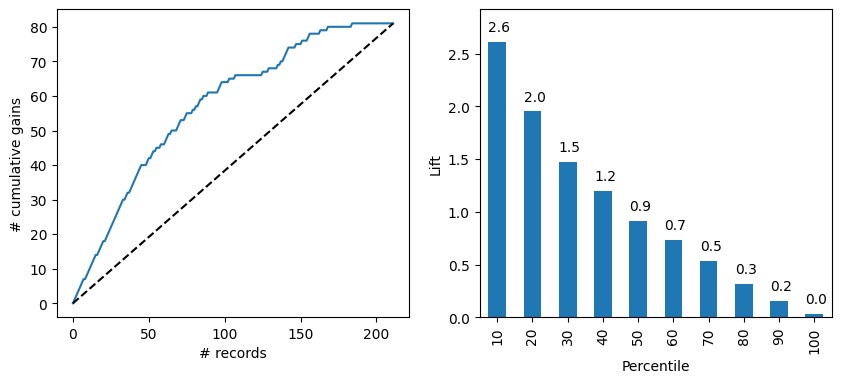

In [ ]:
df = logit_result.sort_values(by=['p(1)'], ascending=False)
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))
gainsChart(df.actual, ax=axes[0])
liftChart(df['p(1)'], title=False, ax=axes[1])
plt.show()

In [ ]:
print("\nValidation Set: Confusion matrix\n")
classificationSummary(valid_Y, logit_reg_pred)


Validation Set: Confusion matrix

Confusion Matrix (Accuracy 0.7725)

       Prediction
Actual   0   1
     0 116  14
     1  34  47


In [ ]:
from sklearn.metrics import classification_report
print(classification_report(valid_Y, logit_reg_pred))

              precision    recall  f1-score   support

           0       0.77      0.89      0.83       130
           1       0.77      0.58      0.66        81

    accuracy                           0.77       211
   macro avg       0.77      0.74      0.75       211
weighted avg       0.77      0.77      0.76       211



Feature scaling

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.4, random_state = 1)

In [ ]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [ ]:
from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression(random_state = 1)
classifier.fit(X_train, Y_train)

LogisticRegression(random_state=1)

In [ ]:
#classifier = pd.DataFrame({'actual': valid_Y,'p(0)': [p[0] for p in logit_reg_proba],'p(1)': [p[1] for p in logit_reg_proba],'predicted': logit_reg_pred })

In [ ]:
print(classifier)

LogisticRegression(random_state=1)


In [ ]:
print(Y_train)

236    0
394    0
526    0
562    1
484    0
      ..
179    0
194    0
122    0
285    0
87     0
Name: loses, Length: 315, dtype: int64


In [ ]:
print(X_train)

[[-0.49496623  2.52464548 -0.3703855  ...  1.14576914 -0.13214262
   1.01600102]
 [ 0.53831548  0.07181228 -1.25961074 ... -0.32147337 -0.9590706
   1.01600102]
 [ 1.40156348  0.37167802 -1.48960392 ...  0.98967951 -0.6489726
   1.01600102]
 ...
 [-1.24049859 -0.58285222  0.24709164 ... -1.05899686 -0.33887461
   1.01600102]
 [-0.1745181   0.62343453 -0.68587027 ...  0.0718725  -0.13214262
   1.01600102]
 [-1.46939011 -0.37189324 -1.14952809 ...  0.98967951 -0.13214262
   1.01600102]]


In [ ]:
Y_pred = classifier.predict(X_test)

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score
cm = confusion_matrix(Y_test, Y_pred)
print(cm)
accuracy_score(Y_test, Y_pred)

[[115  15]
 [ 30  51]]


0.7867298578199052

In [ ]:
df = classifier.sort_values(by=['p(1)'], ascending=False)
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))
gainsChart(df.actual, ax=axes[0])
liftChart(df['p(1)'], title=False, ax=axes[1])
plt.show()

AttributeError: ignored

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(Y_test, Y_pred))

              precision    recall  f1-score   support

           0       0.79      0.88      0.84       130
           1       0.77      0.63      0.69        81

    accuracy                           0.79       211
   macro avg       0.78      0.76      0.77       211
weighted avg       0.79      0.79      0.78       211

